In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import pandas as pd
from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import importlib as il
from tqdm import tqdm

import fast_time_interp

import pyIGRF as pyigrf
import apexpy
from apexpy import Apex

from multiprocessing import Pool
from itertools import repeat

os.cpu_count()

40

In [2]:
path_to_sat_files = 'temp/F16_2013_75-77_interped_SAMI-INTERP-new.nc'

satdf = xr.open_dataset(path_to_sat_files)

print(satdf)

'''
# Check for the first satellite passing on 17 March
satdf = satdf.where(satdf.sat_time.dt.day == 17, drop = 'True')

satdf = satdf.isel(sat_step=slice(62177, 63971))
print(satdf)
''';

<xarray.Dataset>
Dimensions:    (sami_time: 596, sat_step: 258508)
Coordinates:
  * sami_time  (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
    glat       (sat_step) float64 ...
    glon       (sat_step) float64 ...
    alt        (sat_step) float64 ...
    sat_time   (sat_step) datetime64[ns] ...
Dimensions without coordinates: sat_step
Data variables:
    edens      (sami_time, sat_step) float64 ...


In [8]:
fast_time_interp = il.reload(fast_time_interp)

interpolations = fast_time_interp.edens_sattime(satdf)

# if you want to do it for a specific date then mention the date as the second argument

#interpolations = fast_time_interp.edens_sattime(satdf, 17)


100%|██████████████████████████████████| 172340/172340 [05:44<00:00, 500.92it/s]


172340
<xarray.Dataset>
Dimensions:        (sami_time: 596, sat_step: 172340)
Coordinates:
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
    glat           (sat_step) float64 2.8 2.9 2.9 3.0 ... 80.5 80.5 80.5 80.5
    glon           (sat_step) float64 261.2 261.2 261.2 ... 145.8 145.5 145.2
    alt            (sat_step) float64 854.7 854.7 854.7 ... 861.9 861.9 861.9
    sat_time       (sat_step) datetime64[ns] 2013-03-16 ... 2013-03-17T23:59:59
Dimensions without coordinates: sat_step
Data variables:
    edens          (sami_time, sat_step) float64 0.0 0.0 ... 3.071e+04 3.061e+04
    interpd_edens  (sat_step) float64 0.0 141.4 282.3 ... 2.203e+04 2.197e+04
    mlat           (sat_step) float64 23.29 23.34 23.34 ... 76.04 76.03 76.02
    mlon           (sat_step) float64 -27.36 -27.37 -27.37 ... -157.1 -157.3
<xarray.Dataset>
Dimensions:        (sami_time: 596, sat_step: 86165)
Coordinates:
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ...

(0.0, 300000.0)

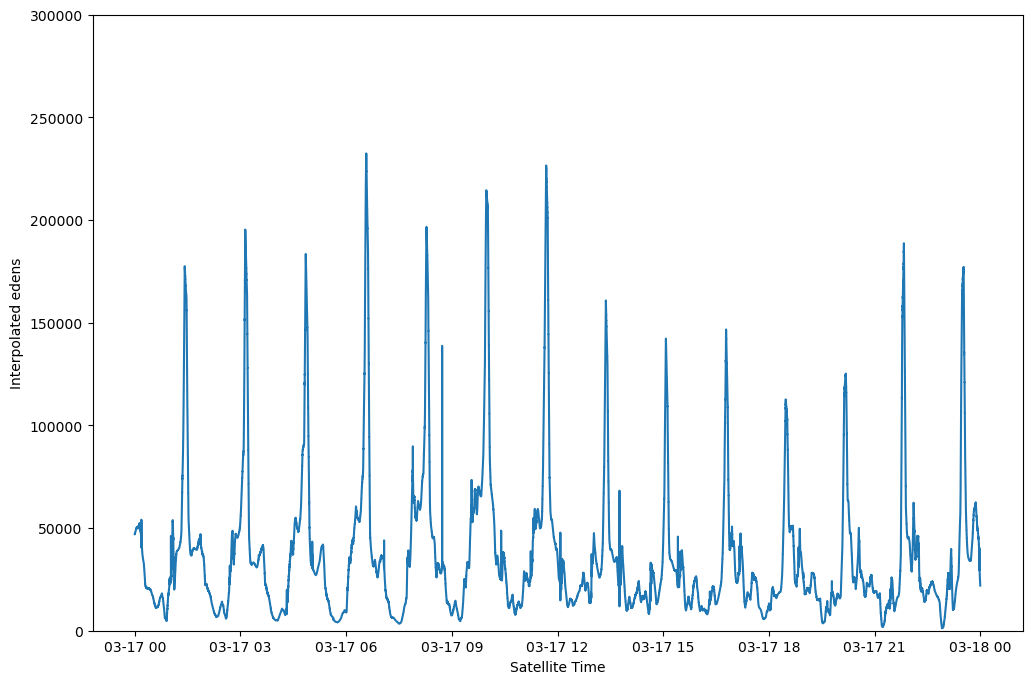

In [11]:
print(len(interpolations))
print(satdf)

satdf['interpd_edens'] = ('sat_step', interpolations)

satdf1 = satdf.where(satdf.sat_time.dt.day != 18, drop='True')
satdf1 = satdf.where(satdf1.sat_time.dt.day != 16, drop='True')

print(satdf1)

plt.figure(figsize=(12,8))
plt.plot(satdf1['sat_time'], satdf1['interpd_edens'])
plt.xlabel('Satellite Time')
plt.ylabel('Interpolated edens')
plt.ylim(0,300000)


In [3]:
# Storing some satellite passes

start_ind = [1168, 7268, 13368, 56149, 62177, 68232]
end_ind = [2989, 9176, 15392, 57955, 63971, 70011]
nature = ['quiet', 'quiet', 'quiet', 'storm', 'storm', 'storm']
path = 'time_interpolated_data/'
start_time = ['0020', '0202', '0344', '1539', '1719', '1901']
num = ['1', '2', '3', '4', '5', '6']

file_path = []

for n, na, st in zip(num, nature, start_time):
    fpath = path + n + '_' + na + '_' + st + '_sat_pass.nc'
    file_path.append(fpath)
print(file_path)


['time_interpolated_data/1_quiet_0020_sat_pass.nc', 'time_interpolated_data/2_quiet_0202_sat_pass.nc', 'time_interpolated_data/3_quiet_0344_sat_pass.nc', 'time_interpolated_data/4_storm_1539_sat_pass.nc', 'time_interpolated_data/5_storm_1719_sat_pass.nc', 'time_interpolated_data/6_storm_1901_sat_pass.nc']


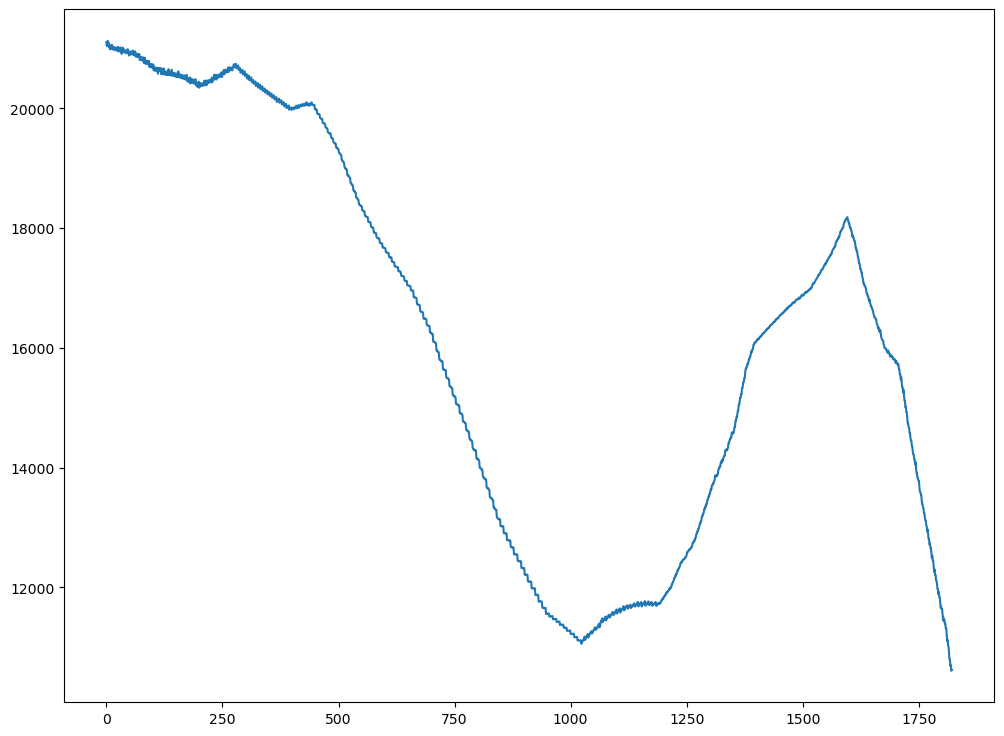

In [6]:
satdf2 = satdf.where(satdf.sat_time.dt.day ==17, drop='True')

for s, e, f in zip(start_ind, end_ind, file_path):
    sat_pass = satdf2.isel(sat_step = slice(s, e+1))
    sat_pass.to_netcdf(f)

sat1 = xr.open_dataset(file_path[0])
sat1
plt.figure(figsize=(12,9))
plt.plot(sat1['interpd_edens'])

# Calculating the Magnetic Coordinates

In [5]:
satdf = xr.open_dataset('time_interpolated_data/sat_data.nc')
print(satdf)

<xarray.Dataset>
Dimensions:        (sat_step: 172340, sami_time: 596)
Coordinates:
    glat           (sat_step) float64 ...
    glon           (sat_step) float64 ...
    alt            (sat_step) float64 ...
    sat_time       (sat_step) datetime64[ns] ...
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
Dimensions without coordinates: sat_step
Data variables:
    interpd_edens  (sat_step) float64 ...
    edens          (sami_time, sat_step) float64 ...


(0.0, 300000.0)

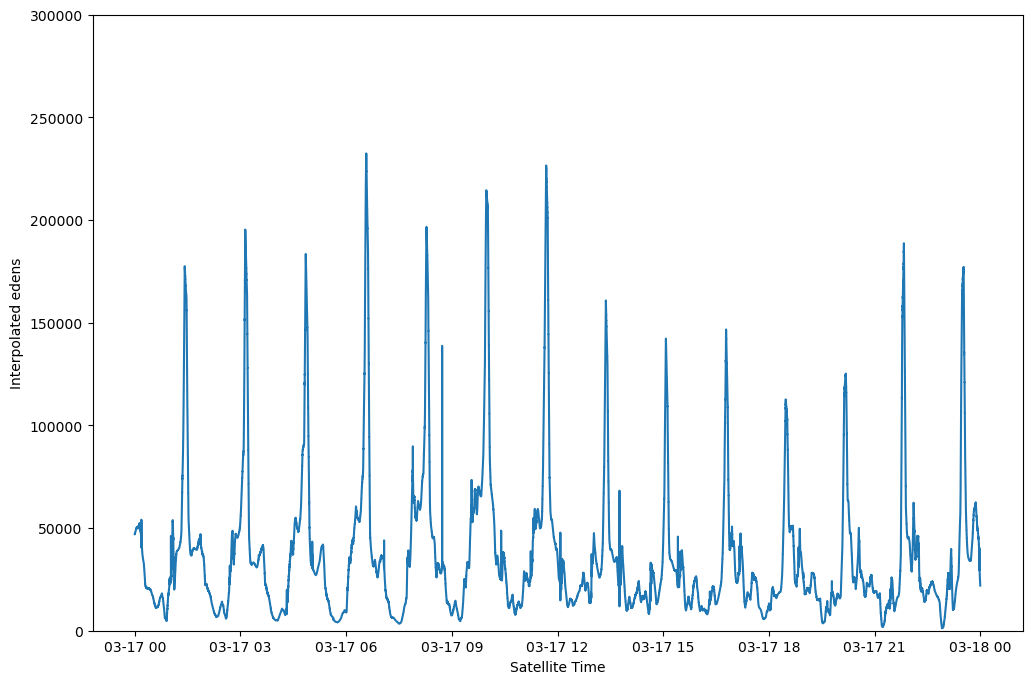

In [9]:
satdf = satdf.where(satdf.sat_time.dt.day == 17, drop='True')

plt.figure(figsize=(12,8))
plt.plot(satdf['sat_time'], satdf['interpd_edens'])
plt.xlabel('Satellite Time')
plt.ylabel('Interpolated edens')
plt.ylim(0,300000)

In [13]:
fast_time_interp = il.reload(fast_time_interp)

sat_mag = fast_time_interp.magnetic_coords(satdf)
sat_mag.to_netcdf('time_interpolated_data/sat_data.nc')


sat_mag1 = fast_time_interp.magnetic_coords(satdf1)
sat_mag1.to_netcdf('time_interpolated_data/sat_data_day_17.nc')

sat_mag1

100%|███████████████████████████████████| 86165/86165 [00:19<00:00, 4349.91it/s]


<xarray.Dataset>
Dimensions:        (sami_time: 596, sat_step: 86165)
Coordinates:
  * sami_time      (sami_time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
    glat           (sat_step) float64 48.0 48.1 48.1 48.2 ... 80.5 80.5 80.5
    glon           (sat_step) float64 252.0 252.0 251.9 ... 145.8 145.5 145.2
    alt            (sat_step) float64 859.4 859.4 859.4 ... 861.9 861.9 861.9
    sat_time       (sat_step) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:59
Dimensions without coordinates: sat_step
Data variables:
    edens          (sami_time, sat_step) float64 0.0 0.0 ... 3.071e+04 3.061e+04
    interpd_edens  (sat_step) float64 4.703e+04 4.703e+04 ... 2.197e+04
    mlat           (sat_step) float64 58.09 58.18 58.16 ... 76.04 76.03 76.02
    mlon           (sat_step) float64 -42.91 -42.92 -43.05 ... -157.1 -157.3

# Writing the code for the satellite passes

In [48]:
pass_day = 17
pass_num = 1


def sat_pass(sat_data, day, num):
    
    sat_data.where(sat_data.dt.data == pass_day, drop = True)
    
    mlat = sat_data['mlat']
    
    print(np.where(mlat > 55 and mlat < 54.9))
    return

sat_pass(satdf, 17, num)

    